# Using `mlcolvar` with graph neural network Committor (GNN Committor)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alphatestK/GNN-Committor/blob/main/tutorials/adv_gnn_committor.ipynb)

##### NOTE
Most of the workings of the library are the same using standard feed-forward-nn-based machine-learning CVs or GNN-based ones.
Thus, it is recommended to first go through the basic tutorials for the standard scenario before moving to this tutorial.

### Feed-Forward-based CVs vs GNN-based CVs

The default setting of `mlcolvar` is to represent the CVs as the output nodes of Feed-Forward Neural Networks (FFNNs or NNs, for simplicity) which take as input a set of physical descriptors (e.g., distances, angles, etc.).
The code is thus designed to reflect this choice, with the default values of the classes set to intilialize the CV model in this framework, which is the most diffused for the time being in the field of machine-learning CVs and suits the needs of most users.

However, recently a different approach have been proposed, in which the CVs are represented as Graph Neural Networks (GNNs) which directly take as input the Cartesian coordinates of the atoms in the studied system and return the CV space after a node-pooling operation on the output layer.
This approach is thus descriptor-free and goes in the direcion of a more automated way of desgining CVs.
Unfortunately, it typically comes at a higher computational cost (i.e., slower trainign and evaluation fo the CV) and the underlying codebase is more complex (i.e., more complex models and data format.)

In this tutorial, we show how GNN models can be used within `mlcolvar` to build Committor using the implemented methods.


In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

### Outline
Typically, the process of constructing a GNN-based CV requires the following ingredients;
1. A **dataset** of attributed connected graphs (nodes and edges), which are constructed from the atomic positions
2. A **GNN-model** to represent the CV. Different architectures can be used in this regard.
 

### Load data
#### The inputs of GNNs CVs
The input of GNN models are attributed and connected graphs, in which nodes (representing the atoms, in our case) are connected by edges (the lines of the graph).
Nodes and edges are then assigned with scalar and, eventually, vector features that are then processed through the layers of the GNN.

In the context of GNN-CVs, such graphs most likely are created directly from the atomic coordinates from a trajectory file and the connectivity between the nodes is determined according to a radial `cutoff`.

#### Truncated graphs
In some cases, graphs can be built focusing the attention on a subset of the whole system, e.g., a molecule on a surface, but still keeping into account the interaction with the environment, e.g., the surface.
In this case, only the ndoes from the `system_selection` will be used for the final pooling, whereas the nodes from the `enviroment_selection` will be used only to update the information through the layers.
Moreover, to reduce the computational costs, only the atoms closer to the `system_selection` atoms will be included in the graphs, according to the set `cutoff` and a `buffer` value to ensure stability e continuity. 
For example, this setup is useful when treting solvent or surface interactions.

#### Create dataset from trajectory files
To make this process easier, in `mlcolvar` there is an util function to do this under-the-hood: `create_dataset_from_trajectories`, which is analogous to the create_dataset_from_files used with descriptors.
The loading process is built on the external library [`MDTraj`](https://www.mdtraj.org/), which can natively load most common trajectory+topology format used in biophysics.
On the other hand, for less-bio applications (e.g., solids, surfaces, molecules) we recommend using the `.xyz` file format.

One advantage of MDTraj, is that it comes with a simple and user friendly synthax for atom selection, which can be used also here.

Here, as an example, we load some data about the state A and B of Alanine Dipeptide.

In [3]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_trajectories

# loading arguments 
# same as to laod_dataframe
load_args = [{'start' : 0, 'stop' : 5000, 'stride' : 5},
               {'start' : 0, 'stop' : 5000, 'stride' : 5}]

# create dataset
dataset = create_dataset_from_trajectories(
    trajectories=["traj_r.dcd",     
                  "traj_p.dcd"],
    top="nacl.pdb",               
    folder="data_nacl",      
    cutoff=6.0,  # Angstrom   
    buffer =1.0,     
    labels=None,  
    system_selection='type Na or type Cl',
    environment_selection='type O',                
    show_progress=False,
    load_args=load_args,
    lengths_conversion=10.0, # MDTraj uses nm by defualt, we use Angstroms
    )
print('Dataset info:\n', dataset, end="\n\n")

# load dataset into a DictModule
datamodule = DictModule(dataset=dataset)
# datamodule = DictModule(dataset=dataset, batch_size=1000)
print('Datamodule info:\n', datamodule)

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
Dataset info:
 DictDataset( "data_list": 2000, "z_table": [8, 11, 17], "cutoff": 6.0, "used_idx": tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115

#### Accessing graph data
The built graphs are then stored as `torch_geometric.Data` objects into the usual `DictDataset` with the information about each graph entry (e.g., nodes positons, edges, weights, elabels etc.) under tehe key `data_list` and the common information for all the graphs (e.g., map from types to chemical species, cutoff) in the `metadata` attribute dictionary.

In [4]:
print('Example of a graph entry:\n', dataset['data_list'][0], end='\n\n')
print('Dataset metadata:\n', dataset.metadata)

Example of a graph entry:
 Data(edge_index=[2, 1186], shifts=[1186, 3], unit_shifts=[1186, 3], positions=[68, 3], cell=[3, 3], node_attrs=[68, 3], graph_labels=[1, 1], n_system=[1, 1], n_env=[1, 1], system_masks=[68, 1], weight=1.0, names_idx=[68])

Dataset metadata:
 {'z_table': [8, 11, 17], 'cutoff': 6.0, 'used_idx': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 12

### Initializing the GNN model
At variance with the procedure with FFNNs, here the model is initialized **outside** the CV class, to which is then passed only later as an input.
GNN architectures are indeed much more complex than FFNNs and have many parameters that can be set.
In addition, when introducing GNN models into the code, we maintained the standard CVs as the default, which still covers most of the users.

Here, for example, we initialize a `SchNetModel`.
Many other architectures are available in [`pytorch_geometric`](https://pytorch-geometric.readthedocs.io/en/latest/) and can be readily adapted to this library.

#### NOTE
As the input graph are built with the dataset and then processed in the GNN-model, it is wise to initialize the model directly refering to the values stored in the `dataset.metadata` (e.g., cutoff, z_table)

In [5]:
from mlcolvar.core.nn.graph.schnet import SchNetModel

gnn_model = SchNetModel(n_out=1,
                        cutoff=dataset.metadata['cutoff'],
                        atomic_numbers=dataset.metadata['z_table'],
                        n_bases=14,
                        n_layers=3,
                        n_filters=28,
                        n_hidden_channels=24,
                        w_out_after_pool=True,
                        aggr='min'
                    )

### Initializing Committor model
The initalization of the CV class is almost identical to the standard committor case, with the only difference that we provide the initialized GNN object as model.


In [6]:
import torch
from mlcolvar.cvs import Committor

from mlcolvar.cvs.committor.utils import initialize_committor_masses 
# we can still set the options for the optimizer the usual way
# options for the BLOCKS of the cv are disabled when passing an external model
options = {'optimizer' : {'lr' : 6e-4,'weight_decay': 1E-6},
           'lr_scheduler': {
            'scheduler': torch.optim.lr_scheduler.ExponentialLR,
            'gamma': 0.99992}
        }

# atomic_masses = initialize_committor_masses(atom_types=[0, 0, 1, 2, 0, 0, 0, 1, 2, 0], 
#                                             masses=[12.011, 15.999, 14.007])
atomic_masses= torch.Tensor([ 15.999, 22.989, 35.45])
model = Committor(
        atomic_masses=atomic_masses,
        # atomic_masses = None,  # Atomic masses will be extracted from graph data automatically
        separate_boundary_dataset=False,
                    alpha=10,
                    delta_f=0,
                    n_dim=1,    # Set n_dim =1 for Graph data
                    log_var= True,
                    model=gnn_model)


/home/pkang@iit.local/miniconda3/envs/mlcolvar_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


### Training the Committor
Here, everything works the same!

In [7]:
from lightning import Trainer
from mlcolvar.utils.trainer import MetricsCallback
from mlcolvar.utils.plot import plot_metrics
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
# define callbacks

metrics = MetricsCallback()
checkpoint_callback = ModelCheckpoint(dirpath="./modelsave/", save_top_k=10, monitor="train_loss_epoch", every_n_epochs=50)
early_stopping = EarlyStopping(
    monitor='train_loss',
    patience=100,
    min_delta=1E-5,
    stopping_threshold=-15,
)
# initialize trainer, for testing the number of epochs is low, change this to something like 4/5000 at least
trainer = Trainer(callbacks=[metrics, checkpoint_callback,early_stopping], max_epochs=50, logger=False, enable_checkpointing=True,enable_model_summary=False,
            accelerator='cpu'
        )

# trainer = Trainer(
#     callbacks=[metrics],
#     logger=False,
#     enable_checkpointing=False,
#     max_epochs=5,
#     enable_model_summary=False
# )

trainer.fit(model, datamodule)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/pkang@iit.local/miniconda3/envs/mlcolvar_new/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/pkang@iit.local/miniconda3/envs/mlcolvar_new/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/pkang@iit.local/work/committor_gnn/github/tutorial/modelsave exists and is not empty.


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/pkang@iit.local/miniconda3/envs/mlcolvar_new/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/pkang@iit.local/miniconda3/envs/mlcolvar_new/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


/home/pkang@iit.local/miniconda3/envs/mlcolvar_new/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/pkang@iit.local/miniconda3/envs/mlcolvar_new/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 1/1 [00:12<00:00,  0.08it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:12<00:00,  0.08it/s]


#### Plot training metrics

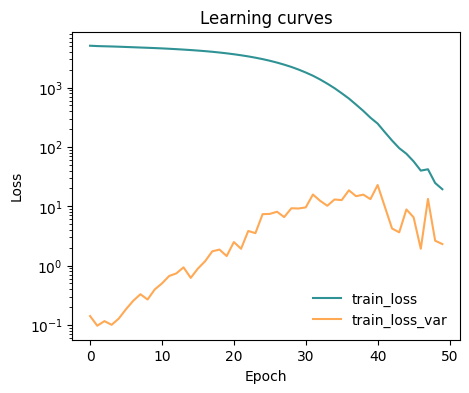

In [8]:

# plot metrics
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log',)

### Testing the model
As the graph data are stored as `torch_geometric.Data` they need to be loaded using a loader object.
For convenience, we implemented both in `DictDataset ` and `DictModule` a method `.get_graph_data` to do it so that one can simply evaluate the model calling either:
- `model(dataset.get_graph_data())` --> Returns the **whole dataset**
- `model(datamodule.get_graph_data())` --> Returns either the **train or valid dataset**

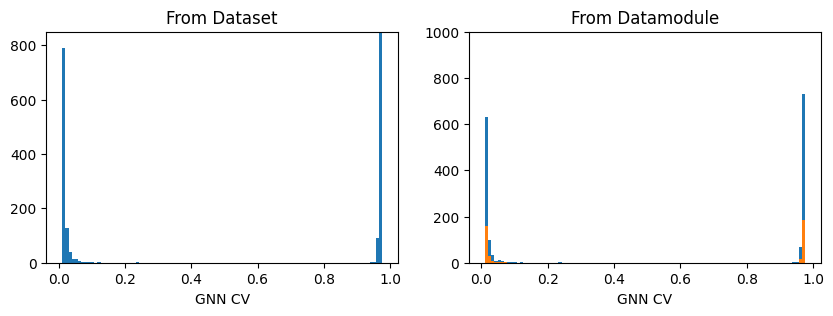

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,3))

ax = axs[0]
out_graph = model(dataset.get_graph_inputs())
ax.hist(out_graph.detach().squeeze(), bins=100)
ax.set_title('From Dataset')
ax.set_xlabel('GNN CV')
ax.set_ylim(0,850)

ax = axs[1]
out_graph = model(datamodule.get_graph_inputs("train"))
ax.hist(out_graph.detach().squeeze(), bins=100)
out_graph = model(datamodule.get_graph_inputs("valid"))
ax.hist(out_graph.detach().squeeze(), bins=100)

ax.set_title('From Datamodule')
ax.set_xlabel('GNN CV')
ax.set_ylim(0,1000)
plt.show()

### Save the model to TorchScript
As for normal CVs, the frozen model can be saved to TorchScript suing the `Lightning` util `to_torchscript` using `method=trace`.

In [10]:
traced_model = model.to_torchscript('gnn_model.pt', method='trace')

# we can also check the outputs coincide
torch.allclose(model(dataset.get_graph_inputs()), traced_model(dataset.get_graph_inputs()))

/home/pkang@iit.local/miniconda3/envs/mlcolvar_new/lib/python3.11/site-packages/mlcolvar/data/datamodule.py:322: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(


False